In [1]:
import numpy as np
import pickle
import torch
import time
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import src.learning as lrn
from src.safetymaps import StaticSafetyMap, DynamicSafetyMap
from src.reachsteering import HdaGreedy, HdaReachSteering
from src.visualization import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

c:\Users\ktomita3\.conda\envs\pygmo3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def visualize_traj(hda):
    t, X, U = hda.construct_trajectory()
    fig, axs = plot_3sides(t[:-1], X, U=None, uskip=1)
    n_traj = len(hda.X_list)
    for i in range(n_traj):
        t_ = hda.t_list[i]
        X_ = hda.X_list[i]
        U_ = hda.U_list[i]
        fig, axs = plot_3sides(t_[:-1], X_, U=None, uskip=1, fig=fig, axs=axs, linetype='k:')

        axs[0, 0].scatter(X_[0, 0], X_[0, 1], marker='o', color='r')
        axs[1, 0].scatter(X_[0, 0], X_[0, 2], marker='o', color='r')
        axs[1, 1].scatter(X_[0, 1], X_[0, 2], marker='o', color='r')

    # tight layout
    plt.tight_layout()

    return fig, axs

def visualize_profiles(hda, lander):
    t, X, U = hda.construct_trajectory()
    plot_vel(t, X, lander.vmax)
    plot_mass(t, X, lander.mdry, lander.mwet)
    plot_thrust_mag(t[:-1], U, lander.rho2, lander.rho1)
    plot_pointing(t[:-1], U, lander.pa)
    

In [90]:
def visualize_nn_reach(hda, n_skip=1, fontsize=16):
    # make font times new roman
    plt.rcParams["font.family"] = "Times New Roman"

    sfmap_list = hda.sfmap_list[1:]
    reach_mask_list = hda.reachmask_list
    t_list = hda.t_list

    # skip
    sfmap_list = sfmap_list[::n_skip]
    reach_mask_list = reach_mask_list[::n_skip]
    t_list = t_list[::n_skip]
    # print their len
    print(f'Number of maps: {len(sfmap_list)}')
    print(f'Number of reachability masks: {len(reach_mask_list)}')
    print(f'Number of time steps: {len(t_list)}')
    

    n_map = len(sfmap_list) 
    fig, axs = plt.subplots(1, n_map, figsize=(5*n_map, 6), sharey=True, sharex=True)
    for i in range(n_map):

        sfmap = sfmap_list[i]
        reach_mask = reach_mask_list[i]
        t = t_list[i][0]
    

        n = int(np.sqrt(sfmap.shape[0]))

        x = sfmap[:, 0].reshape(n, n)
        y = sfmap[:, 1].reshape(n, n)
        safety = sfmap[:, 2].reshape(n, n)
        reach_mask = reach_mask.reshape(n, n)

        # Safety Map
        safety_img = axs[i].pcolormesh(x, y, safety, shading='auto', cmap='gray', vmin=0, vmax=1)
        #plt.colorbar(safety_img, ax=axs[i], orientation='vertical', label='Safety')

        # Reachability Set - as the overlay with transparency
        reach_mask[reach_mask <= 0.4] = np.nan
        reachability_img = axs[i].pcolormesh(x, y, reach_mask, shading='auto', cmap='jet', alpha=0.5, vmin=0, vmax=1)
        #plt.colorbar(reachability_img, ax=axs[i], orientation='vertical', label='Reachability')

        axs[i].set_title(f't={t:.0f} s', fontsize=fontsize)
        if i == 0:
            axs[i].set_ylabel('y, m', fontsize=fontsize)
        axs[i].set_xlabel('x, m', fontsize=fontsize)
        axs[i].set_aspect('equal')
        # set font size
        axs[i].tick_params(labelsize=fontsize)


    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([1.0, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
    fig.colorbar(safety_img, ax=axs[-1], cax=cbar_ax)
    # colorbar ticks font size
    cbar_ax.tick_params(labelsize=fontsize)
    # colorbar label
    cbar_ax.set_ylabel("Safety", rotation=270, labelpad=20, fontsize=fontsize)
    # tight layout
    plt.tight_layout()
    return fig, axs

In [2]:
with open('../saved/controllable_set/lander.pkl', 'rb') as f:
        lander = pickle.load(f)

hidden_layers = [256, 256, 256]
nn_reach = lrn.NeuralReach(hidden_layers=hidden_layers)
nn_reach.load_state_dict(torch.load('../saved/controllable_set/reachset_train/20231115-025054/models_20231130-175526/mlp_reach/mlp_reach.pt'))
nn_reach.eval()

#sfmap_model = StaticSafetyMap(x_range=(-300, 300), y_range=(-300, 300), npoints=100)
sfmap_model = DynamicSafetyMap(x_range=(-300, 300), y_range=(-300, 300), npoints=100, relative_path="..")

x0_init = np.array([-100.0, 0.0, 1300.0, 20.0, 5, -55.0, lander.mwet])
tof = 60.0
T = 5.0
dt = 0.5

In [3]:
hda_greedy = HdaGreedy(lander, sfmap_model, nn_reach, border_sharpness=10.0)
hda_greedy.solve_hda(x0_init, tof, T, dt)

x0: [-100.    0. 1300.   20.    5.  -55. 1905.], tgo: 60.0
Greedy HDA optimized single leg: 4.398703575134277 sec
x0: [-3.91204939e+01  1.13961704e+01  1.05549349e+03  5.22143299e+00
 -8.57690937e-02 -4.22420109e+01  1.87497622e+03], tgo: 55.0
Greedy HDA optimized single leg: 1.6494202613830566 sec
x0: [-2.66971867e+01  7.78500875e+00  8.85547479e+02  2.48158213e-01
 -1.18710772e+00 -2.55647628e+01  1.84495661e+03], tgo: 50.0
Greedy HDA optimized single leg: 1.3857715129852295 sec
x0: [-2.88872974e+01  2.43105735e+00  8.01477354e+02 -1.08291312e+00
 -9.54845266e-01 -7.96397628e+00  1.81494891e+03], tgo: 45.0
Greedy HDA optimized single leg: 1.2412753105163574 sec
x0: [-3.60369370e+01 -1.93947383e+00  7.79374643e+02 -1.62726338e+00
 -8.24259623e-01 -5.70698253e+00  1.79790273e+03], tgo: 40.0
Greedy HDA optimized single leg: 1.2376620769500732 sec
x0: [-4.50672439e+01 -6.05810052e+00  7.39082167e+02 -1.96676108e+00
 -8.20524432e-01 -1.03984226e+01  1.78663679e+03], tgo: 35.0
Greedy HDA o

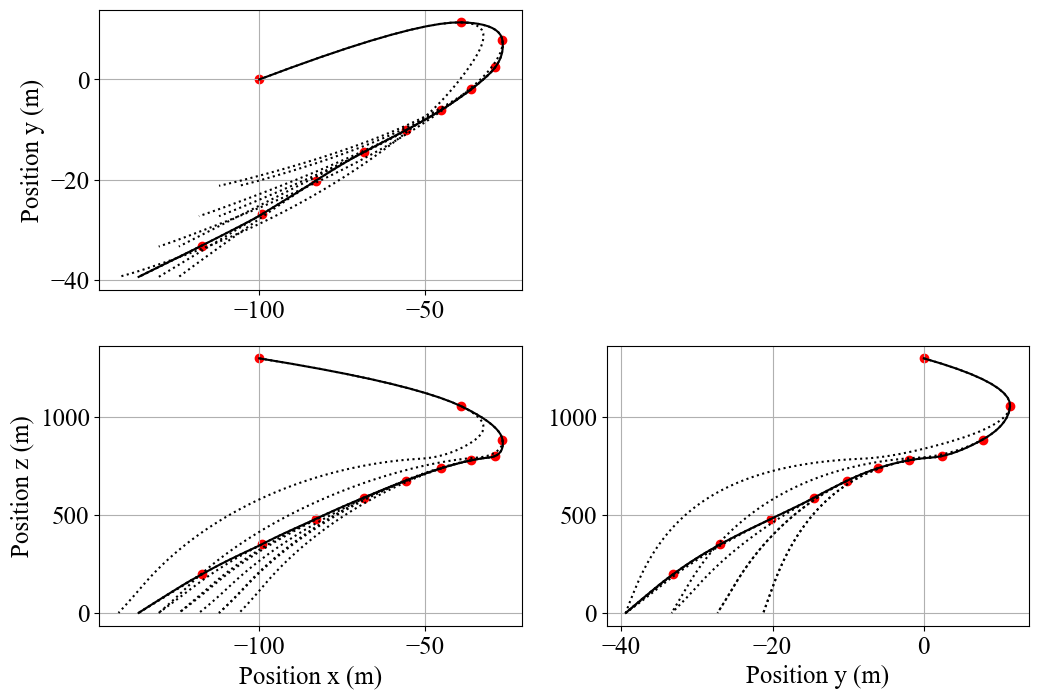

In [85]:
fig, ax = visualize_traj(hda_greedy)
fig.savefig('../saved/fig/traj_greedy.pdf', bbox_inches='tight')


In [ ]:
visualize_profiles(hda_greedy, lander)

Number of maps: 6
Number of reachability masks: 5
Number of time steps: 6


IndexError: list index out of range

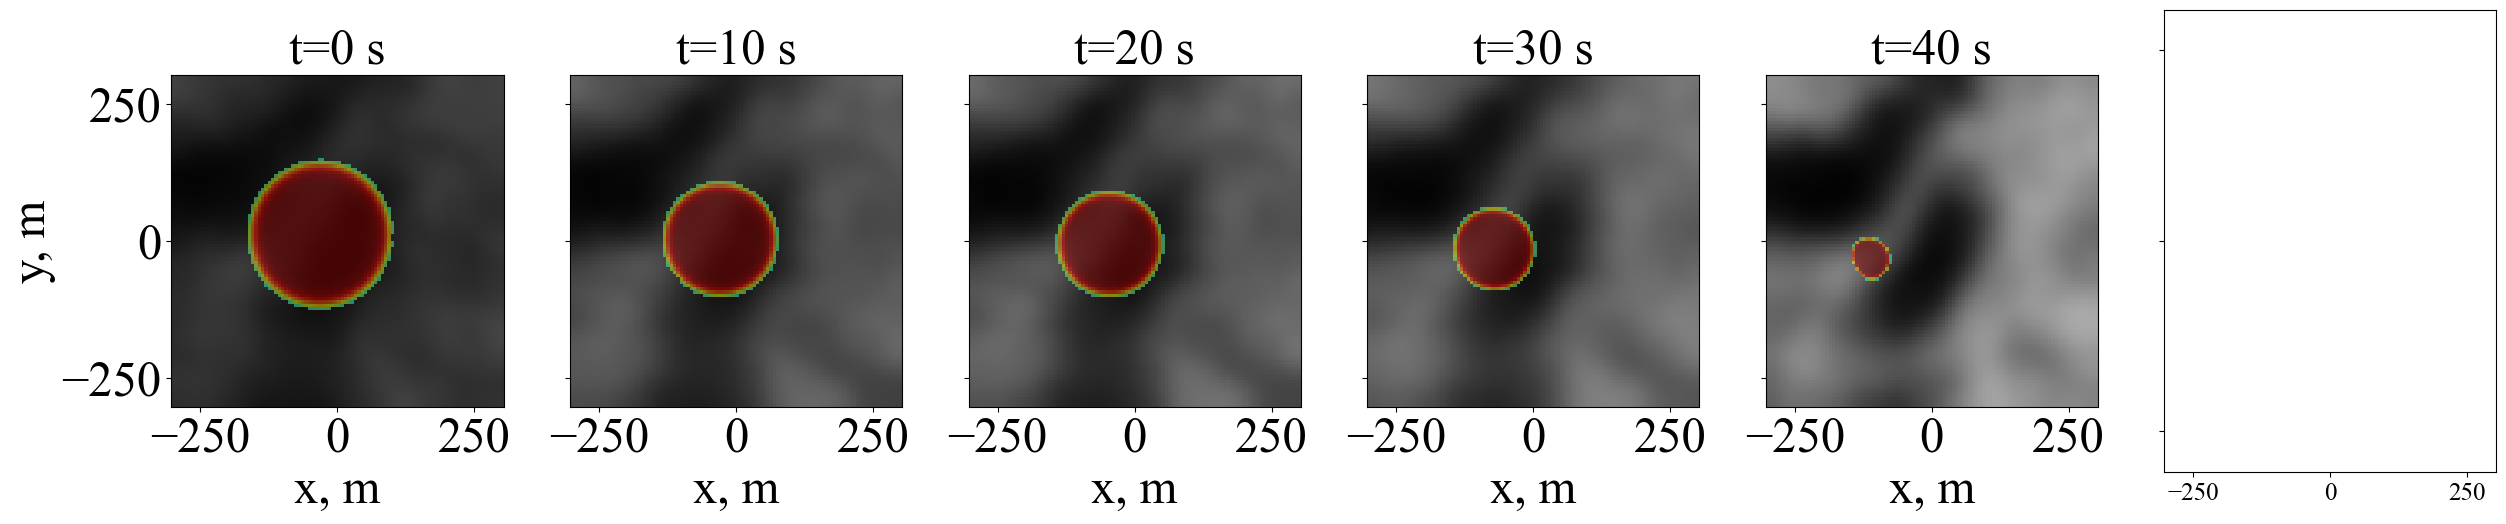

In [91]:
fig, ax = visualize_nn_reach(hda_greedy, n_skip=2, fontsize=35)
#fig.savefig('../saved/fig/reachset_greeedy.pdf', bbox_inches='tight')
# save png as well
fig.savefig('../saved/fig/reachset_greeedy.png', bbox_inches='tight', dpi=500)


In [62]:
hda_rs = HdaReachSteering(lander, sfmap_model, nn_reach, border_sharpness=10.0)
hda_rs.solve_hda(x0_init, tof, T, dt)

x0: [-100.    0. 1300.   20.    5.  -55. 1905.], tgo: 60.0
Greedy HDA optimized single leg: 1.5095329284667969 sec
Reach-steering HDA optimized single leg: 16.807520151138306 sec
x0: [-4.41304005e-01  2.50000000e+01  1.06589124e+03  1.82347840e+01
  5.00000000e+00 -3.89773148e+01  1.87495236e+03], tgo: 55.0
Greedy HDA optimized single leg: 1.7503509521484375 sec
Reach-steering HDA optimized single leg: 6.899379730224609 sec
x0: [  74.22759766   44.14636137  911.66470371   11.74023791    2.70351145
  -22.59371979 1844.90853382], tgo: 50.0
Greedy HDA optimized single leg: 1.3838915824890137 sec
Reach-steering HDA optimized single leg: 4.4454615116119385 sec
x0: [ 132.92878721   57.66391862  786.04971569   11.74023791    2.70351145
  -27.63862248 1833.64180269], tgo: 45.0
Greedy HDA optimized single leg: 1.4357688426971436 sec
Reach-steering HDA optimized single leg: 5.370707035064697 sec
x0: [ 1.95764855e+02  6.46998662e+01  6.42991073e+02  1.27131504e+01
  1.17842683e+00 -3.08124181e+01

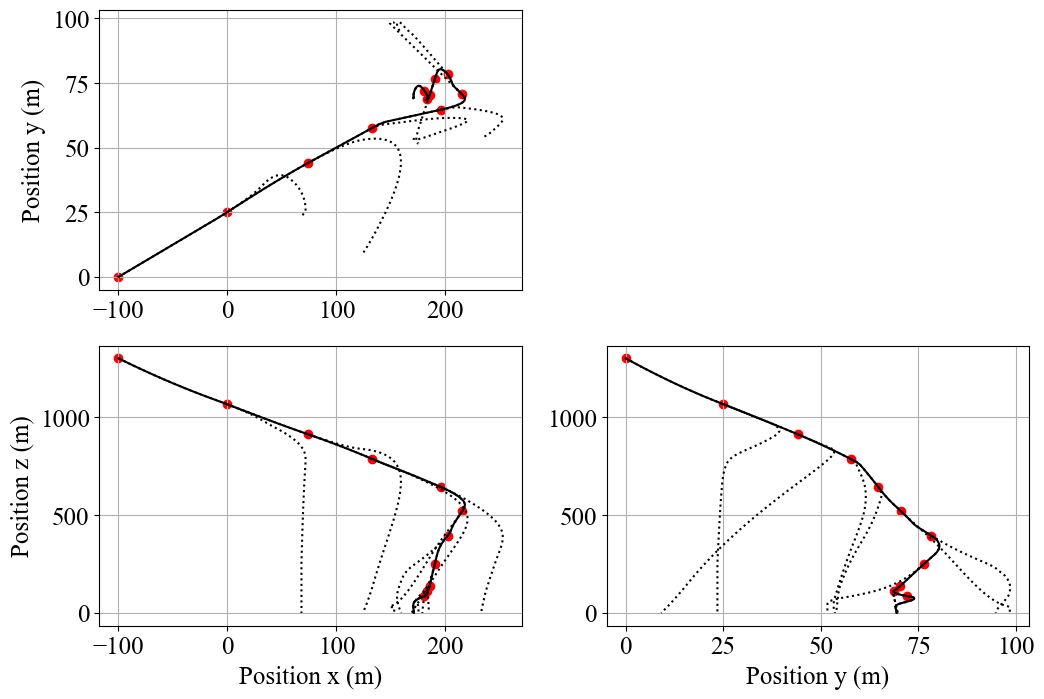

In [84]:
fig, ax = visualize_traj(hda_rs)
fig.savefig('../saved/fig/traj_rs.pdf', bbox_inches='tight')

In [ ]:
visualize_profiles(hda_rs, lander)

Number of maps: 6
Number of reachability masks: 6
Number of time steps: 6


C:\Users\ktomita3\AppData\Local\Temp\ipykernel_30952\3918061582.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


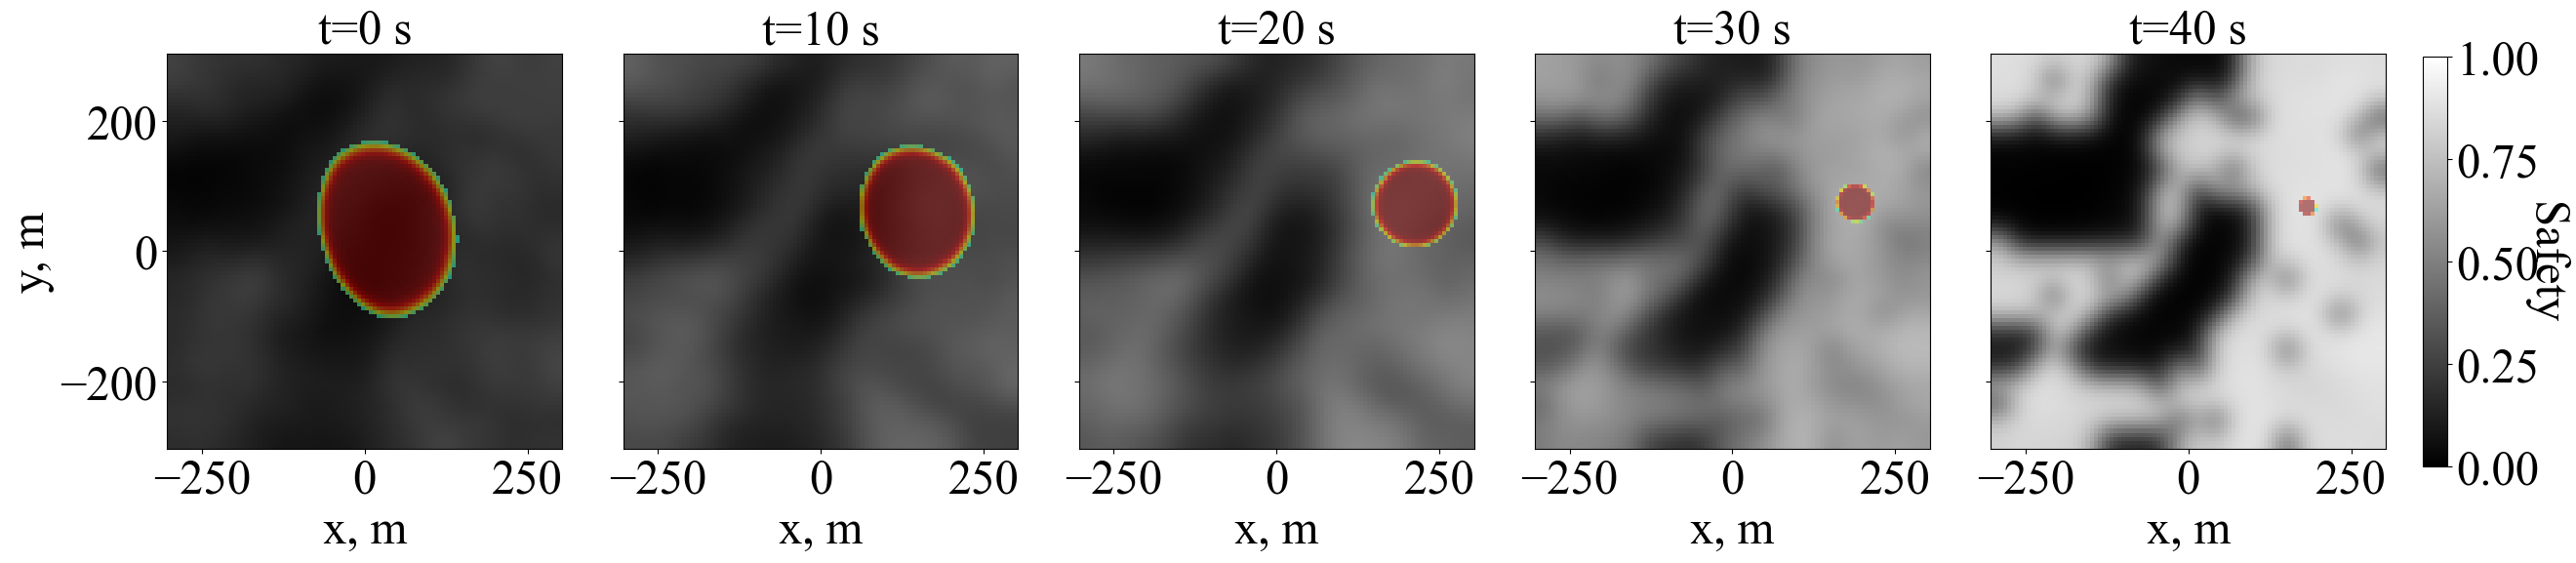

In [88]:
fig, ax = visualize_nn_reach(hda_rs, n_skip=2, fontsize=35)
fig.savefig('../saved/fig/reachset_rs.pdf', bbox_inches='tight')
# save png as well
fig.savefig('../saved/fig/reachset_rs.png', bbox_inches='tight', dpi=500)

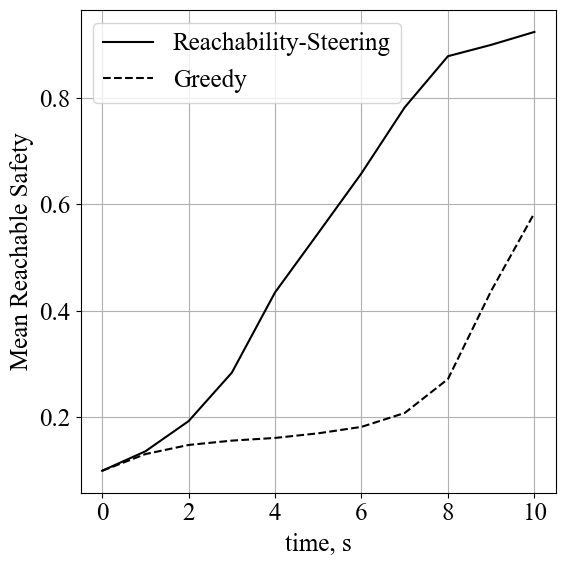

In [76]:
# font size
fontsize = 18
plt.figure(figsize=(6, 6))
plt.plot(np.arange(11), hda_rs.mean_safety_list, 'k-', label='Reachability-Steering')
plt.plot(np.arange(11), hda_greedy.mean_safety_list, 'k--', label='Greedy')
plt.xlabel('time, s', fontsize=fontsize)
plt.ylabel('Mean Reachable Safety', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
# tight layout
plt.tight_layout()
# grid
plt.grid(True)
# save
plt.savefig('../saved/fig/mean_reachable_safety.pdf')